# Tasks
In this project, we use the music data set described in [Defferrard et al.(2017)](https://arxiv.org/pdf/1612.01840.pdf) to achieve two tasks.

### Task 1: Build a music searcher based on the user-specified music character vector. 
A Music character vector include acousticness, danceability, energy, instrumentalness, liveness, speechiness, tempo (normalized), valence. These are the labels.

**Steps** 
* Build a predictor for music character vector based on a small portion of labeled data [label for this subset provided by spotify]
* Search for a new music with user-specified music character vector, based on Euclidean distance


### Task 2: Build a music generator to create new music based on user-specified music character vector.
An user can also enjoy newly created music in addition to existing ones. 

* Build a music generator using RNN model with LSTM (or GRU) cell, using music tracks in a neighborhood of the user-specified music character vector as training data
* Generate new music based on the user-specified music character vector and a prime sequence.

### Data Background and Description

Raw Data sets: can be obtained from [Here](https://github.com/mdeff/fma)

> **tracks.csv**: per track metadata such as ID, title, artist, genres, tags and play counts, for all 106,574 tracks.

> **genres.csv**: all 163 genre IDs with their name and parent (used to infer the genre hierarchy and top-level genres).

> **features.csv**: nine audio features extracted with librosa, computed across time and summarized with seven statistics of each feature (mean, standard deviation, skew, kurtosis, median, minimum, maximum). Features include Chroma (84 attributes), Tonnetz (42 attributes), Mel Frequency Cepstral Coefficient (MFCC) (140 attributes), Spectral centroid (7 attributes), Spectral bandwidth (7 attributes), Spectral contrast (49 attributes), Spectral rolloff (7 attributes),  Root Mean Square energy (7 attributes), Zero-crossing rate (7 attributes)

> **echonest.csv**: audio features provided by Echonest (now Spotify) for a subset of 13,129 tracks. The rest of the data set does not contain the audio features.

In [3]:
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import helper
import scipy.io.wavfile as wav
import pydub

Using TensorFlow backend.


### Creating Dataset for this Project
> **data_labeled_extracted_feature.csv**: 13,129 tracks, each track includes the summary statistics of nine categories of features of the music tracks. In each category, there are subcategories. Moreover, each track is labeled (values for all the aspects in the music character are known)
> **data_full_extracted_feature.csv**: 106,574 tracks, summary statistics of features for the full data set, the tracks are not labeled except the subset of 13,129 tracks



In [22]:
#Load and Join two datasets, will use music character vector from 'echonest' as labels, and use variables in features
#as feature vector
echonest = pd.read_csv('echonest.csv', index_col=0, header=[0, 1, 2])
features = pd.read_csv('features.csv', index_col=0, header=[0, 1, 2])

#normalization of tempo to be in [0,1]
temp = max(echonest['echonest','audio_features','tempo'])
echonest['echonest','audio_features','tempo_normalized'] = echonest['echonest','audio_features','tempo']/temp
del echonest['echonest','audio_features','tempo']

#Each row of data_labeled_extracted_feature includes feature vector and label vector
data_labeled_extracted_feature = echonest.join(features, how = 'inner').sort_index(axis=1)
data_labeled_extracted_feature.to_csv('data_labeled_extracted_feature.csv', encoding = 'utf-8')

#Most rows of data_full_extracted_feature only include feature vector but miss label vector (from spotify). 
#We train a predictor to fill in these missing character vectors 
data_full_extracted_feature = echonest.join(features, how = 'outer').sort_index(axis=1)
data_full_extracted_feature.to_csv('data_full_extracted_feature.csv', encoding = 'utf-8')

data_labeled_extracted_feature['echonest','audio_features'].to_csv('data_labeled_extracted_feature_label.csv', 
                                                                encoding = 'utf-8')

## Task 1: Build a Music Searcher Based on User-specified Music Character Vector 

### Task 1.1 Predict Labels of Musics for the Full Dataset

In [4]:
#Loading data with labels
data_labeled_extracted_feature = pd.read_csv('data_labeled_extracted_feature.csv', index_col=0, header=[0, 1, 2])
print('{1} features for {0} tracks'.format(*data_labeled_extracted_feature.shape))
#print('columns of data_labeled_extracted_feature', data_labeled_extracted_feature.columns.levels[0:2])

767 features for 13129 tracks


### Exploratory Analysis of Variables in Echonest

In [5]:
print('Audio Features of echonest')
ipd.display(data_labeled_extracted_feature['echonest', 'audio_features'].head())

print('Social Features of echonest')
ipd.display(data_labeled_extracted_feature['echonest', 'social_features'].head())

print('Other Information')
ipd.display(data_labeled_extracted_feature['echonest', 'ranks'].head())
ipd.display(data_labeled_extracted_feature['echonest', 'metadata'].head())

Audio Features of echonest


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo_normalized,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.660854,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.505660,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.399328,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.444343,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.455208,0.894072


Social Features of echonest


,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss
track_id,,,,,
2,0.388990,0.386740,0.406370,0.000000,0.000000
3,0.388990,0.386740,0.406370,0.000000,0.000000
5,0.388990,0.386740,0.406370,0.000000,0.000000
10,0.557339,0.614272,0.798387,0.005158,0.354516
134,0.388990,0.386740,0.406370,0.000000,0.000000


Other Information


,artist_discovery_rank,artist_familiarity_rank,artist_hotttnesss_rank,song_currency_rank,song_hotttnesss_rank
track_id,,,,,
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
10,2635.0,2544.0,397.0,115691.0,67609.0
134,NaN,NaN,NaN,NaN,NaN


,album_date,album_name,artist_latitude,artist_location,artist_longitude,artist_name,release
track_id,,,,,,,
2,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
3,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
5,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
10,2008-03-11,Constant Hitmaker,39.9523,"Philadelphia, PA, US",-75.1624,Kurt Vile,Constant Hitmaker
134,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life


### Summary Statistics of the Music Character Vector
* acousticness: acoustic music primarily uses instruments that produce sound through acoustic means, as opposed to electric or electronic means. 
* danceability: degree of danceability 
* energy: degree of energy
* instrumentalness: as name suggests
* liveness: as name suggests
* speechiness: an estimate of the amount of spoken word in a particular track. This may not be used in generating music. 
* valence: the emotion of music, anger and fear have "negative valence", while joy has "positive valence"
* tempo_normalized: normalized version of tempo, where tempo of a music track is speed of the underlying beat, measured in Beats Per Minute (BPM). 60 BPM is one beat/second

In [6]:
data_labeled_extracted_feature['echonest','audio_features'].describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo_normalized,valence
count,1.312900e+04,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000
mean,5.246876e-01,0.487290,0.537516,0.640536,0.187804,0.099174,0.490218,0.439761
std,3.837186e-01,0.190148,0.278049,0.361430,0.158051,0.137381,0.139463,0.276028
min,9.035000e-07,0.051307,0.000020,0.000000,0.025297,0.022324,0.050794,0.000010
25%,1.037726e-01,0.344759,0.321300,0.323466,0.101406,0.036932,0.382229,0.197321
50%,5.739848e-01,0.485635,0.549113,0.838134,0.119002,0.049019,0.478178,0.417743
75%,9.207270e-01,0.629094,0.776254,0.918244,0.211041,0.085452,0.578790,0.665575
max,9.957965e-01,0.968645,0.999964,0.998016,0.980330,0.966177,1.000000,0.999990


### Plotting Variables in the Music Character Vector

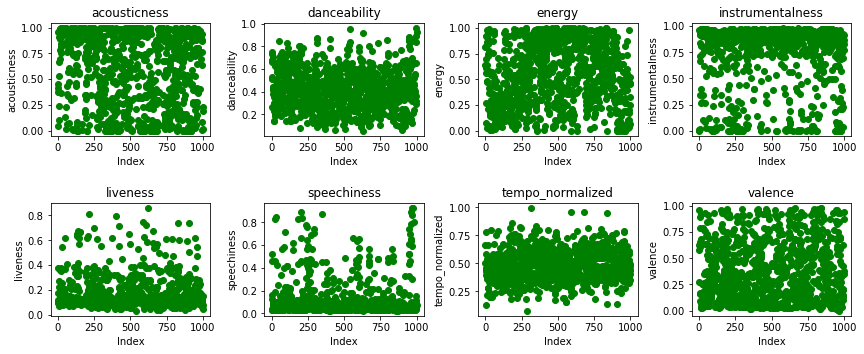

In [7]:
y_label = ['acousticness','danceability','energy','instrumentalness',
           'liveness','speechiness','tempo_normalized','valence'] 
num_tracks = 1000
plt.figure(figsize=(12,5))
for i, j in enumerate(y_label):
    plt.subplot(2, 4, i+1)
    plt.plot(np.array(data_labeled_extracted_feature['echonest','audio_features',j])[:num_tracks],'og')
    plt.title(j)
    plt.xlabel('Index')
    plt.ylabel(j)

plt.tight_layout(pad=1, w_pad=1, h_pad=2)
plt.show()

### Create Train and Test Data

In [8]:
#Create training, validation, and testing set
data_train, data_test = sk.model_selection.train_test_split(data_labeled_extracted_feature, 
                                                            test_size=0.2, 
                                                            random_state=42)
data_train.shape,data_test.shape
#data_train['echonest','audio_features'].head()

((10503, 767), (2626, 767))

### Define the Set of Features

In [9]:
features = pd.read_csv('features.csv', index_col=0, header=[0, 1, 2])
feature_set = list(features.columns.levels[0])
#feature_set = ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz', 'zcr']
X_train = data_train[feature_set]
X_test = data_test[feature_set]

### Choose a Preferred Regression Method from a Family of Methods

* Compare the performances of different regression estimators in their respective default settings to roughly assess the potential of each method for this dataset, choose the one with the best performance, and optimize over its hyperparameters.
* A more thorough approach would be: for each label, optimizing over hyperparameter for each regression method, and choose the best among the best.

In [8]:
import timeit
methods = ['Lasso', 'Ridge', 'Random Forest', 'GBDT', 'MLP']
r2_mat_train = np.zeros((len(y_label), len(methods)))
r2_mat_test = np.zeros((len(y_label), len(methods)))

start_time = timeit.default_timer()
for i, label in enumerate(y_label):
    y_train = data_train['echonest','audio_features',label]
    y_test = data_test['echonest','audio_features',label]
    
    for j, method in enumerate(methods):
        y_predicted_train, y_predicted_test, _, r2_train, r2_test = helper.predictor_fitted_assess_potential(X_train,
                                                                                                             y_train,
                                                                                                             X_test,
                                                                                                             y_test,
                                                                                                             method = method)
        r2_mat_train[i,j] = r2_train
        r2_mat_test[i,j] = r2_test
    
elapsed = timeit.default_timer() - start_time
print('Time Elapsed is {0:0.2f} (in seconds)'.format(elapsed))

Time Elapsed is 1157.51 (in seconds)


In [12]:
r2_df_train = pd.DataFrame(r2_mat_train, index = y_label, columns = methods)
print('r2 score table for training data for different labels and methods')
r2_df_train

r2 score table for training data for different labels and methods


,Lasso,Ridge,Random Forest,GBDT,MLP
acousticness,0.376257,0.672965,0.928247,0.736138,-0.915415
danceability,0.244432,0.546351,0.893912,0.591032,-3.774088
energy,0.636373,0.800846,0.955753,0.831876,-1.062419
instrumentalness,0.170977,0.411928,0.869136,0.511444,-0.742454
liveness,0.058404,0.243469,0.835829,0.380470,-0.481748
speechiness,0.081686,0.418925,0.886229,0.636281,-0.214256
tempo_normalized,0.025521,0.113026,0.813352,0.190191,-5.089806
valence,0.067826,0.488536,0.875823,0.533969,-1.040387


In [11]:
r2_df_test = pd.DataFrame(r2_mat_test, index = y_label, columns = methods)
print('r2 score table for testing data for different labels and methods')
r2_df_test

,Lasso,Ridge,Random Forest,GBDT,MLP
acousticness,0.341285,0.619849,0.578898,0.646657,-0.919047
danceability,0.214922,0.462267,0.398512,0.474060,-3.885229
energy,0.611953,0.748095,0.749210,0.771560,-1.111245
instrumentalness,0.163495,0.370615,0.306383,0.411167,-0.740730
liveness,0.059470,0.167904,0.086592,0.206136,-0.469839
speechiness,0.078060,0.365304,0.433758,0.505570,-0.217034
tempo_normalized,0.020925,-0.008585,-0.050364,0.030903,-5.081295
valence,0.061539,0.420167,0.324291,0.416237,-1.052819


From the above tables for testing data, GBDT has the best performance.

### Use the GBDT Predictor to Generate the Character Vector for Each Track in the Full Dataset

In [22]:
y_label = ['acousticness','danceability','energy','instrumentalness',
           'liveness','speechiness','tempo_normalized','valence'] 

data_full_extracted_feature = pd.read_csv('data_full_extracted_feature.csv', 
                                          index_col=0, header=[0, 1, 2], low_memory = False)
print('data_full_extracted_feature is of shape ', data_full_extracted_feature.shape)

data_full_extracted_feature is of shape  (106574, 767)


In [23]:
data_full_extracted_audio_feature = data_full_extracted_feature['echonest','audio_features']
#data_full_extracted_audio_feature.head()

#subset is the index set for those without music character vector
subset_no_labels = data_full_extracted_feature.index[np.isnan(data_full_extracted_feature['echonest', 
                                                                                'audio_features', 
                                                                                'acousticness'])]
X_subset_no_labels = data_full_extracted_feature.loc[subset_no_labels][feature_set]

### For each Label, Run GBDT with GridSearch and Use the Best One for Prediction

In [9]:
import timeit

r2_mat_gbdt = np.zeros((len(['Train','Test']), len(y_label)))
start_time = timeit.default_timer()
for i, label in enumerate(y_label):
    y_train = data_train['echonest','audio_features', label]
    y_test = data_test['echonest','audio_features', label]
    y_predicted_train, y_predicted_test, predictor, r2_mat_gbdt[0,i], r2_mat_gbdt[1,i] = helper.predictor_fitted_gbdt_best(X_train,
                                                                                                                           y_train,
                                                                                                                           X_test,
                                                                                                                           y_test)

    y_predicted_subset_no_labels = predictor.predict(X_subset_no_labels)
    data_full_extracted_feature['echonest','audio_features', label].loc[subset_no_labels] = y_predicted_subset_no_labels
    
elapsed = timeit.default_timer() - start_time
print('Time Elapsed is {0:0.2f} (in seconds)'.format(elapsed))

Time Elapsed is 13051.59 (in seconds)


In [19]:
r2_df_gbdt = pd.DataFrame(np.around(r2_mat_gbdt, decimals = 4), index = ['Train','Test'], columns = y_label)
r2_df_gbdt

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo_normalized,valence
Train,0.9283,0.8565,0.9467,0.8396,0.7760,0.9185,0.1901,0.8456
Test,0.6788,0.5033,0.7793,0.4509,0.2098,0.5359,0.0309,0.4509


#### Write the Enriched Data to a csv File

In [ ]:
data_full_extracted_feature['echonest','audio_features'].to_csv('data_full_extracted_feature_label.csv', 
                                                                encoding = 'utf-8')
#data_full_extracted_feature['echonest','audio_features'].iloc[0:10]

### Finding Music Tracks Closest to A User-Specified Character Vector and Play the Closest Song

In [61]:
char_vec_dict = {'acousticness': 0.5, 'danceability': 0.5, 'energy': 0.5, 'instrumentalness': 0.5,
                'liveness': 0.5, 'speechiness': 0.5, 'tempo_normalized': 0.5, 'valence': 0.5}
#'speechiness': float('nan')
char_vec = np.array(list(char_vec_dict.values()))

num_songs = 100     #Number of songs to form the train and test data, in a neighborhood of the specified music character
database = 'large'
closest_indexes = helper.find_music_indexes(char_vec, number = num_songs, database = database) #Returns a list of numbers

closest_indexes_updated_format = []  
for i in range(len(closest_indexes)):
    closest_indexes_updated_format.append('{:06d}'.format(closest_indexes[i]))

print('Closest Indexes in the {} Music Data are : '.format(database))
np.array(closest_indexes_updated_format)

Closest Indexes in the large Music Data are : 


array(['130867', '024745', '155003', '020625', '110511', '072424',
       '092573', '113909', '033384', '033469', '122758', '114370',
       '045338', '040728', '075972', '020855', '013936', '093110',
       '141405', '008325', '089617', '067312', '096067', '013858',
       '138603', '152037', '086923', '024746', '141319', '125939',
       '022854', '065985', '075128', '037533', '110512', '119328',
       '112178', '138156', '115208', '087485', '132343', '010417',
       '010256', '085093', '024747', '119371', '059829', '025235',
       '130882', '025853', '026606', '047635', '042133', '019882',
       '119326', '006713', '086142', '038375', '119323', '009451',
       '119369', '038379', '063171', '151016', '067323', '037314',
       '107050', '086427', '043306', '143886', '041336', '045415',
       '039414', '010233', '009149', '009148', '043330', '025715',
       '027888', '022839', '067074', '009456', '087336', '084418',
       '119378', '091888', '119335', '095658', '090314', '0203

In [62]:
input_path = 'D:/Music-Analysis/Data_mp3'
output_path = 'D:/Music-Analysis/Data_wav'

music_name_mp3 = str(closest_indexes_updated_format[0])+str('.mp3')
path_mp3 = os.path.join(input_path, music_name_mp3)
ipd.Audio(filename = path_mp3)

## Extra Analysis (Associated with Task I) for Fun

### 1. An illustration of the Fit using 'acousticness' as Label

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

y_train = data_train['echonest','audio_features','acousticness']
y_test = data_test['echonest','audio_features','acousticness']

param_grid = {
    'max_depth': [3,6,9]
    #'max_features': [50,100,150,200,400],
    #'min_samples_leaf': [10,30,50,100]
}
gbdt = sk.ensemble.GradientBoostingRegressor(random_state = 0, loss = 'ls')
Grid_CV_gbdt = GridSearchCV(estimator = gbdt, param_grid = param_grid, cv = 5)
Grid_CV_gbdt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=0, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 6, 9]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [14]:
Grid_CV_gbdt.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=0, subsample=1.0, verbose=0,
             warm_start=False)

In [39]:
y_predicted_train = Grid_CV_gbdt.best_estimator_.predict(X_train)
y_predicted_test = Grid_CV_gbdt.best_estimator_.predict(X_test)

print("Mean squared error for Training Data: {:.4f}".format(mean_squared_error(y_train.as_matrix(), y_predicted_train)))
print("r2_score for Training Data: {:.4f}".format(r2_score(y_train.as_matrix(), y_predicted_train)))
print("Mean squared error for Testing Data: {:.4f}".format(mean_squared_error(y_test.as_matrix(), y_predicted_test)))
print("r2_score for Testing Data: {:.4f}".format(r2_score(y_test.as_matrix(), y_predicted_test)))

Mean squared error for Training Data: 0.0106
r2_score for Training Data: 0.9284
Mean squared error for Testing Data: 0.0466
r2_score for Testing Data: 0.6788


In [43]:
y_predicted_train_random = np.random.uniform(0,1,len(y_train.as_matrix()))
y_predicted_test_random = np.random.uniform(0,1,len(y_test.as_matrix()))
print("r2_score for Training Data under Random Prediction: {:.4f}".format(r2_score(y_train.as_matrix(), y_predicted_train_random)))
print("r2_score for Testing Data under Random Prediction: {:.4f}".format(r2_score(y_test.as_matrix(), y_predicted_test_random)))

r2_score for Training Data under Random Prediction: -0.5614
r2_score for Testing Data under Random Prediction: -0.5731


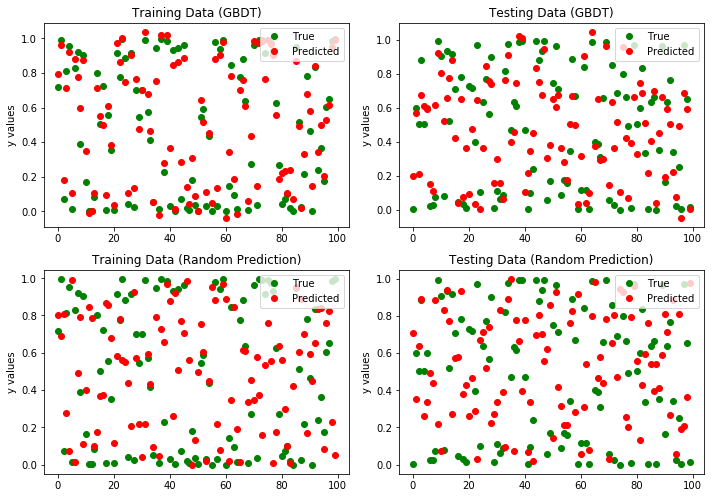

In [55]:
#Plot the True and Predicted for both Train and Test Data (the first 100 samples)
helper.plot_fit(y_train, y_predicted_train, y_test, y_predicted_test, method = '(GBDT)')

### 2. Plot the Distributions of Labels for Full Data Set

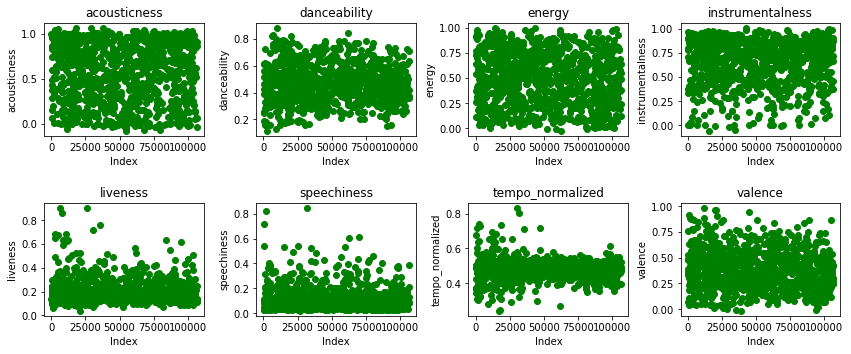

In [60]:
data_full_extracted_feature_label = pd.read_csv('data_full_extracted_feature_label.csv', index_col = None)

num_tracks = 1000
indexes = np.random.randint(0, data_full_extracted_feature_label.shape[0], num_tracks)

plt.figure(figsize=(12,5))
for i, j in enumerate(y_label):
    plt.subplot(2, 4, i+1)
    plt.plot(data_full_extracted_feature_label[j][indexes],'og')
    plt.title(j)
    plt.xlabel('Index')
    plt.ylabel(j)

plt.tight_layout(pad=1, w_pad=1, h_pad=2)
plt.show()

### 3. K-mean Clustering Analysis 
* Clustering divides the full data set into subsamples
* Visualize the clusters

#### 3.1 PCA and Clustering for Visual Exploration

In [49]:
from sklearn.decomposition import PCA

num_clusters = 8
pca = sk.decomposition.PCA(n_components = 2)
label_pca = pca.fit_transform(data_full_extracted_feature_label[y_label])

from sklearn import cluster 
cluster = sk.cluster.KMeans(n_clusters = num_clusters)
label_clustered = cluster.fit_predict(label_pca)

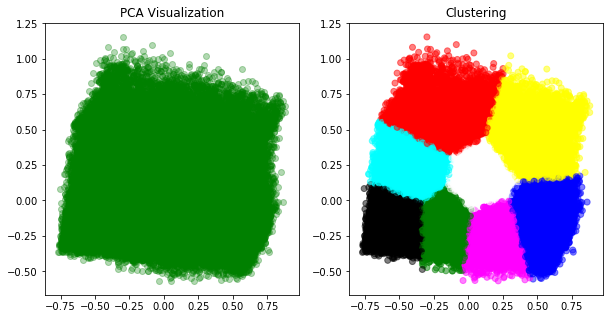

In [50]:
plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
plt.scatter(label_pca[:,0],label_pca[:,1], c='g',alpha=0.3)
plt.title('PCA Visualization')

# Define our own color map
label_color_map = {0:'red', 1:'green', 2:'blue', 3:'yellow', 4: 'black', 5:'magenta', 6:'cyan', 7:'white'}
label_color = [label_color_map[l] for l in label_clustered]

# Plot the scatter digram
plt.subplot(1, 2, 2)
plt.scatter(label_pca[:,0], label_pca[:,1], c = label_color, alpha = 0.5)
plt.title('Clustering')
plt.show()

#### 3.2 K-Mean Clustering Based on the Original Labels and Centers of Clusters

In [52]:
cluster = sk.cluster.KMeans(n_clusters = num_clusters).fit(data_full_extracted_feature_label[y_label])

row_names = ['Cluster '+str(i) for i in range(1, num_clusters+1)]
column_names = y_label

cluster_center_df = pd.DataFrame(data = cluster.cluster_centers_,
                                columns = column_names,
                                index = row_names)
cluster_center_df

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo_normalized,valence
Cluster 1,0.831748,0.473791,0.244699,0.309196,0.218433,0.161350,0.450892,0.353182
Cluster 2,0.745221,0.371669,0.698935,0.813977,0.226630,0.104080,0.505483,0.306625
Cluster 3,0.354606,0.565727,0.657509,0.258741,0.195632,0.142517,0.498302,0.576683
Cluster 4,0.731127,0.524939,0.547471,0.701955,0.192485,0.109674,0.495939,0.567337
Cluster 5,0.883931,0.395981,0.211905,0.822273,0.176473,0.073477,0.450674,0.254391
Cluster 6,0.128997,0.637376,0.627817,0.746692,0.166879,0.120393,0.499816,0.509775
Cluster 7,0.341576,0.487950,0.345592,0.749542,0.177006,0.107574,0.474269,0.241888
Cluster 8,0.239522,0.398016,0.807434,0.715117,0.220497,0.099118,0.520066,0.370331


#### 3.3 Counting Musics in Different Clusters

In [62]:
cluster_count = np.unique(cluster.labels_, return_counts = True)
cluster_count = np.concatenate((cluster_count[1], cluster_count[1]/106574), axis = 0).reshape(2,num_clusters)

column_names = ['Cluster '+str(i) for i in range(1, num_clusters+1)]
row_names = ['Count', 'Proportion']

cluster_count_df = pd.DataFrame(data = np.around(cluster_count, decimals = 4),
                                columns = column_names,
                                index = row_names)
cluster_count_df

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8
Count,10779.0000,11499.0000,9463.0000,13537.000,22165.000,13076.0000,12874.0000,13181.0000
Proportion,0.1011,0.1079,0.0888,0.127,0.208,0.1227,0.1208,0.1237


#### 3.4 Cluster Membership for One Character Vector

In [89]:
char_vec_dict = {'acousticness': 0.5, 'danceability': 0.5, 'energy': 0.5, 'instrumentalness': 0.5,
                'liveness': 0.5, 'speechiness': 0.5, 'tempo_normalized': 0.5, 'valence': 0.5}
char_vec = np.array(list(char_vec_dict.values()))

cluster_membership = np.asscalar(cluster.predict(char_vec.reshape(1,-1)))
print('This character vector belongs to Cluster {}'.format(cluster_membership))

This character vector belongs to Cluster 2


### Find Music Tracks in Different Subfolders and Copy Them to Another Folder
import os, shutil, fnmatch

def main():
    src = "C:/Users/130270/Downloads/fma_large/fma_large"
    dst = "C:/Users/130270/Downloads/Selected_Musics_Train"
    file_names = input_name_list

    for root, dirnames, filenames in os.walk(src):
        for target in file_names:
            for candidate_filename in fnmatch.filter(filenames, target):
                shutil.copy(os.path.join(root, candidate_filename), dst)

if __name__ == '__main__':
    main()

## Task 2: Generate New Music

### Define the List of Songs to Import for Training

In [3]:
input_path = 'D:/Music-Analysis/Data_mp3'
output_path = 'D:/Music-Analysis/Data_wav'

input_name_list = []
output_name_list = []
for i in range(len(closest_indexes)):
    input_name_list.append(str(closest_indexes_updated_format[i])+str('.mp3'))
    output_name_list.append(str(closest_indexes_updated_format[i])+str('.wav'))

### Create wav files from mp3 files

In [ ]:
for i,j in zip(input_name_list, output_name_list):
    helper.mp3_to_wav(input_path, i, output_path, j)

### Obtain Training Data in FFT Form

In [4]:
block_size = 44100      #size of block when we cut the wav array
time_steps = 10         #time steps for the RNN

X_train, y_train, sampling_rate_vec = helper.build_train_data(output_name_list, output_path, block_size, time_steps)
#X_train: numpy array, shape: (number of examples (sequences) from all the selected musics, time_steps, input_cell_dim)
#y_train: type and shape: same as X_train
#sampling_rate_vec: list of sampling rates, each element corresponds to one track of training music

## Build RNN Structure

In [5]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU

in_neurons = X_train.shape[2] #number of neurons in each cell of a time step
out_neurons = in_neurons
hidden_neurons = [256, 128]

#set return_sequences = True for seq2seq, and return_sequences = True for sequence to one cell.
model = Sequential()  
model.add(GRU(hidden_neurons[0], return_sequences=True, input_shape=(time_steps, in_neurons)))  
model.add(Dropout(0.2)) 
#model.add(LSTM(hidden_neurons[1], return_sequences=True))  #no need to specify the input shape since it is determined by the first step
#model.add(Dropout(0.5)) 

model.add(Dense(out_neurons))  
model.add(Activation("linear"))
model.compile(loss = "mean_squared_error", optimizer = "rmsprop") 

## Train the Model
* Time steps in automatically embedded in the shape of X_train
* Within each epoch, the number of iterations is determined by the number of batches in X_train
* X_train is of dimension (number of training sequences, time_steps, data_dim)

In [7]:
model.fit(X_train, y_train, batch_size=10, epochs=40, validation_split=0.2) 
print('Training complete!')

Train on 156 samples, validate on 40 samples
Epoch 1/40
156/156 [==============================] - 63s - loss: 0.0067 - val_loss: 0.0115
Epoch 2/40
156/156 [==============================] - 63s - loss: 0.0065 - val_loss: 0.0111
Epoch 3/40
156/156 [==============================] - 63s - loss: 0.0057 - val_loss: 0.0111
Epoch 4/40
156/156 [==============================] - 59s - loss: 0.0055 - val_loss: 0.0112
Epoch 5/40
156/156 [==============================] - 61s - loss: 0.0053 - val_loss: 0.0112
Epoch 6/40
156/156 [==============================] - 60s - loss: 0.0051 - val_loss: 0.0113
Epoch 7/40
156/156 [==============================] - 69s - loss: 0.0050 - val_loss: 0.0113
Epoch 8/40
156/156 [==============================] - 76s - loss: 0.0048 - val_loss: 0.0114
Epoch 9/40
156/156 [==============================] - 77s - loss: 0.0048 - val_loss: 0.0114
Epoch 10/40
156/156 [==============================] - 76s - loss: 0.0046 - val_loss: 0.0115
Epoch 11/40
156/156 [=============

### Evaluate the model

In [8]:
scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names, scores*100))

['loss']: 0.51%


### Save the Trained Model
The following will be saved:
* architecture of the model, allowing to re-create the model
* weights of the model
* training configuration (loss, optimizer)
* state of the optimizer, allowing to resume training exactly where you left off.

In [10]:
model.save(os.path.join(os.getcwd(),'model.h5'))  # creates a HDF5 file 'model.h5'
#del model

### Reload the Trained Model

In [ ]:
from keras.models import load_model
model = load_model(os.path.join(os.getcwd(),'model.h5'))

### Generate New Music and Play
The new music is based on model trained from neighborhood musics and a prime sequence

In [39]:
#Creating Prime Sequence
X_train_1st_music, _, _ = helper.build_train_data([output_name_list[0]], output_path, block_size, time_steps)
num_seq = X_train_1st_music.shape[0]

output_path_gen = 'D:/Music-Analysis/Generated_Musics'
output_name_gen_wav = 'Generated_Music.wav'
output_name_gen_mp3 = 'Generated_Music.mp3'

helper.generate_new_music(X_train_1st_music, model, 
                          output_path_gen, 
                          output_name_gen_wav, 
                          output_name_gen_mp3,
                          block_size, 
                          num_seq = num_seq,
                          method = 'non-iterative')

path_wav = os.path.join(output_path_gen, output_name_gen_wav)
#os.remove(path_wav)

path_mp3 = os.path.join(output_path_gen, output_name_gen_mp3)
#ipd.Audio(filename = path_mp3)

### Evaluation Metric I: RMSE
* Distance between the seed music (center of the neighborhood), and its generated music, in terms of numerical representation (each element normalized to [0,1] by dividing by 32767)
* The numerical representation of the seed music is truncated to have the same shape as the numerical representation of the generated music, due to the fact that we cut the tail of the numerical representation of a music in the function helper.build_train_data_one_song().

In [46]:
_, original = helper.wav_to_num(output_path, output_name_list[0])
_, generated = helper.wav_to_num(output_path_gen, output_name_gen_wav)

diff_vec = original[:generated.shape[0],0]-generated
print('The MSE between Seed Music and Generated music is {0:0.4f}'.format(np.mean((diff_vec)**2)))

The MSE between Seed Music and Generated music is 0.0095


In [102]:
generated_random = np.random.uniform(low = min(generated), high = max(generated), size = len(generated))
diff_vec_random = original[:generated_random.shape[0],0]-generated_random
print('The MSE between Seed Music and Randomly Generated music is {0:0.4f}'.format(np.mean((diff_vec_random)**2)))

The MSE between Seed Music and Randomly Generated music is 0.0541


## Graph the wav Form of Musics

In [63]:
%matplotlib inline
helper.mp3_to_wav('D:/Music-Analysis/Generated_Musics/Pair1',
                  '048855_Gen.mp3', 
                  'D:/Music-Analysis/Generated_Musics/Pair1', 
                  '048855_Gen.wav')

helper.mp3_to_wav('D:/Music-Analysis/Generated_Musics/Pair1',
                  '048855.mp3', 
                  'D:/Music-Analysis/Generated_Musics/Pair1', 
                  '048855.wav')

_, gen_wav = wav.read( os.path.join('D:/Music-Analysis/Generated_Musics/Pair1', '048855_Gen.wav') )
_, original_wav = wav.read( os.path.join('D:/Music-Analysis/Generated_Musics/Pair1', '048855.wav') )

In [64]:
#Generate Random Music wav for Comparison
random_wav = np.random.randint(min(gen_wav), max(gen_wav)+1, len(gen_wav))
#random_wav

### Plot the wav Sequences 
* Original Music
* Generated Music by RNN
* Randomly Generated Music

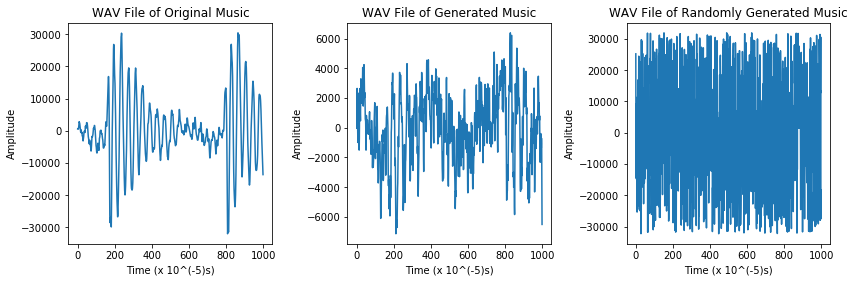

In [68]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)    
plt.plot(original_wav[:len(gen_wav),0][0:1000])
plt.title("WAV File of Original Music")
plt.xlabel("Time (x 10^(-5)s)")
plt.ylabel("Amplitude")

plt.subplot(1, 3, 2)
plt.plot(gen_wav[0:1000])
plt.title("WAV File of Generated Music")
plt.xlabel("Time (x 10^(-5)s)")
plt.ylabel("Amplitude")

plt.subplot(1, 3, 3)
plt.plot(random_wav[0:1000])
plt.title("WAV File of Randomly Generated Music")
plt.xlabel("Time (x 10^(-5)s)")
plt.ylabel("Amplitude")
plt.tight_layout(pad=1, w_pad=1, h_pad=2)

plt.show()

# User Interface (in Progress)

In [2]:
from tkinter import *
y_label = ['acousticness','danceability','energy','instrumentalness',
           'liveness','speechiness','tempo_normalized','valence'] 
var_names = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8']

def slider():
    num_values = 1000
    def show_values(num_values = 1000):
        out = np.array([w1.get(), w2.get(), w3.get(), w4.get(), w5.get(), w6.get(), w7.get(), w8.get()])
        print (out/num_values)
        return out/num_values
    
    master = Tk()
    master.title('Specification of Music Characteristics')
    for w, j in zip(var_names, y_label):
        globals()[w] = Scale(master, from_=0, to=num_values, orient=HORIZONTAL, label = j)
        globals()[w].set(500) #Default value for the slider
        globals()[w].pack(padx=10, pady=10, side=LEFT)
    
    Button(master, text='Play from Database', command = show_values).pack(padx=50, pady=10, side=TOP)
    Button(master, text='Generate New and Play', command = show_values).pack(padx=50, pady=10, side=BOTTOM)
    mainloop()
    
slider()

### Conclusion, Limitations, and Further Improvements 
* Load data onto AWS to train the generator using much more music tracks in the neighborhood. (currently 20)
* Incorporate the DL structure in other works aimed at generating a music with a specified genre [Here](https://www.asimovinstitute.org/analyzing-deep-learning-tools-music), including [Huang and Wu](https://arxiv.org/pdf/1606.04930.pdf), and the paper "Generating Polyphonic Music Using Tied Parallel Networks".